# Process 'Student Internship / Skills Unprepared For' Question Using a LLM

A generic version of the pipeline to be re-used for different types of questions.

Andrew Weng, 1/1/2025

We are going to use a mixed LLM-Python approach to solve the problem of "user text categorization."

This problem can be decomposed into five steps:

1. Pre-process (LLM1)
 - Each user provides up to three keywords as a string. These keywords need to be normalized and stored in a large list of individual keywords for the next stage.
2. Define categories (LLM2)
 - With the list of keywords, find the best set of categories to describe the keywords
3. Assign categories (LLM3)
 - For each keyword, assign it to a category. Be careful about how to handle exceptions (e.g., a keyword that doesn't seem to belog into any particular category.)
4. Count occurences (Python)
 - Within each category, sum up the total number of keywords. 
5. Visualize the results (Python)

In [1]:
import os
import time

current_folder = os.path.basename(os.getcwd())
if current_folder == 'notebooks':
    root_path = os.path.dirname(os.path.abspath(''))
    os.chdir(root_path)

from src.analyst import Analyst
from src.plotter import Plotter
from src.llm import LLM

from collections import defaultdict

import pickle
from pprint import pprint

from IPython import get_ipython
# Automatically reload all modules every time a line of code is executed
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

# Initialize our helper classes

In [3]:
analyst = Analyst()
analyst.load_data()
analyst.build_respondents_list()

plotter = Plotter()
llm = LLM()

# Fetch the relevant dataset to analyze

In [4]:
question = dict()
question['tag'] = 'student_internship_skills_unprepared'
question['question'] = "During your previous internship, were there skills that you felt unprepared for? If yes, what were they?"
question['categories'] = []
question['data'] = analyst.summarize_student_internship()['internship_skills_unprepared_list']

In [5]:
question['data']

['Communication skills',
 'Bussiness skills',
 'DCR',
 '"AI methods; Cloud-based computing"',
 'Yes. Thermal controls, Production codes navigation, Power electronics, Communication systems in sensors',
 'Project Management;',
 'product design',
 'Using Maccor/Arbin cell cyclers, Modeling',
 'Data science',
 'Controls since I have a thermal background',
 'Electrochemical devices',
 'Yes, plotting data',
 'managing managers meetings;',
 'no',
 '[Product Education]',
 '1. Technical Proficiency with Industry Tools, 2. Professional Communication in a Corporate Environment, 3. Time Management and Prioritization',
 'Large project planning',
 'Public speaking, art of negotiations',
 'No']

# Pre-process the user response

Interpret the delimiters

In [6]:
keyword_list = []

for i, string_of_list in enumerate(question['data']):
    print(f"Processing response {i+1} of {len(question['data'])}")
    list_of_strings = llm.delimit_string_of_list(string_of_list)
    print(f'--> {list_of_strings}\n')
    keyword_list.extend(list_of_strings)

# Assemble and cache the list
print(keyword_list)
timestamp = time.strftime('%Y%m%d_%H%M%S')
with open(f'data/strlist_{question['tag']}_{timestamp}.pkl', 'wb') as f:
    pickle.dump(keyword_list, f)

Processing response 1 of 19
--> ['Communication skills']

Processing response 2 of 19
--> []

Processing response 3 of 19
--> []

Processing response 4 of 19
--> ['AI methods', 'Cloud-based computing']

Processing response 5 of 19
--> ['Thermal controls', 'Production codes navigation', 'Power electronics']

Processing response 6 of 19
--> ['Project Management']

Processing response 7 of 19
--> ['product design']

Processing response 8 of 19
--> ['Maccor/Arbin cell cyclers', 'Modeling']

Processing response 9 of 19
--> ['Data science']

Processing response 10 of 19
--> ['Controls', 'thermal background']

Processing response 11 of 19
--> ['Electrochemical devices']

Processing response 12 of 19
--> ['plotting data']

Processing response 13 of 19
--> ['managing managers meetings']

Processing response 14 of 19
--> []

Processing response 15 of 19
--> ['Product Education']

Processing response 16 of 19
--> ['Technical Proficiency with Industry Tools', 'Professional Communication in a Corpo

# Define categories

In [7]:
if question['categories'] == []:

    categories = llm.define_categories(question['question'],
                                       keyword_list,
                                       num_categories=50)

    category_list = []
    for category in categories['categories']:
        category_list.append(category['name'])

else:
    category_list = question['categories']

pprint(category_list)

['Communication Skills',
 'Project Management and Time Management',
 'Artificial Intelligence and Data Science',
 'Cloud Computing',
 'Thermal Engineering',
 'Control Systems Engineering',
 'Power Electronics Engineering',
 'Product Design and Product Knowledge',
 'Electrochemical Devices and Battery Testing Equipment',
 'Data Visualization and Analysis',
 'Software Development and Codebase Navigation',
 'Modeling and Simulation',
 'Technical Tools Proficiency']


# Assign categories

Process one keyword at a time!

In [8]:
content_list = []
other_list = []
fail_list = []

for i, keyword in enumerate(keyword_list):

    print(f"Processing response: '{keyword}' ({i+1} of {len(keyword_list)})...")

    try:
        output = llm.classify_user_response(category_list, keyword,
                                            model='gpt-4o-mini')
    except: # JSON output fails
        fail_list.append(keyword)
        continue

    if output['result']['category'] in category_list:
        content_list.append(output)
    else:
        other_list.append(output)

Processing response: 'Communication skills' (1 of 23)...
Processing response: 'AI methods' (2 of 23)...
Processing response: 'Cloud-based computing' (3 of 23)...
Processing response: 'Thermal controls' (4 of 23)...
Processing response: 'Production codes navigation' (5 of 23)...
Processing response: 'Power electronics' (6 of 23)...
Processing response: 'Project Management' (7 of 23)...
Processing response: 'product design' (8 of 23)...
Processing response: 'Maccor/Arbin cell cyclers' (9 of 23)...
Processing response: 'Modeling' (10 of 23)...
Processing response: 'Data science' (11 of 23)...
Processing response: 'Controls' (12 of 23)...
Processing response: 'thermal background' (13 of 23)...
Processing response: 'Electrochemical devices' (14 of 23)...
Processing response: 'plotting data' (15 of 23)...
Processing response: 'managing managers meetings' (16 of 23)...
Processing response: 'Product Education' (17 of 23)...
Processing response: 'Technical Proficiency with Industry Tools' (18 o

In [9]:
print(len(other_list))

0


In [10]:
other_list

[]

In [11]:
print(len(fail_list))

0


## Assembly dictionary for plotting and a 'collection' dictionary

The 'collection' is a reference for which keywords got sorted into which categories.

In [12]:

collection = defaultdict(list)
counter    = defaultdict(int)

for content in content_list:

    category = content['result']['category']
    response = content['result']['response_text']
    counter[category] += 1
    collection[category].append(response)

counter['_tot_'] = len(question['data'])
counter

defaultdict(int,
            {'Communication Skills': 4,
             'Artificial Intelligence and Data Science': 2,
             'Cloud Computing': 1,
             'Thermal Engineering': 2,
             'Software Development and Codebase Navigation': 1,
             'Power Electronics Engineering': 1,
             'Project Management and Time Management': 4,
             'Product Design and Product Knowledge': 2,
             'Electrochemical Devices and Battery Testing Equipment': 2,
             'Modeling and Simulation': 1,
             'Control Systems Engineering': 1,
             'Data Visualization and Analysis': 1,
             'Technical Tools Proficiency': 1,
             '_tot_': 19})

In [13]:
collection

defaultdict(list,
            {'Communication Skills': ['Communication skills',
              'Professional Communication in a Corporate Environment',
              'Public speaking',
              'art of negotiations'],
             'Artificial Intelligence and Data Science': ['AI methods',
              'Data science'],
             'Cloud Computing': ['Cloud-based computing'],
             'Thermal Engineering': ['Thermal controls', 'thermal background'],
             'Software Development and Codebase Navigation': ['Production codes navigation'],
             'Power Electronics Engineering': ['Power electronics'],
             'Project Management and Time Management': ['Project Management',
              'managing managers meetings',
              'Time Management and Prioritization',
              'Large project planning'],
             'Product Design and Product Knowledge': ['product design',
              'Product Education'],
             'Electrochemical Devices and Battery 

# Visualize the results

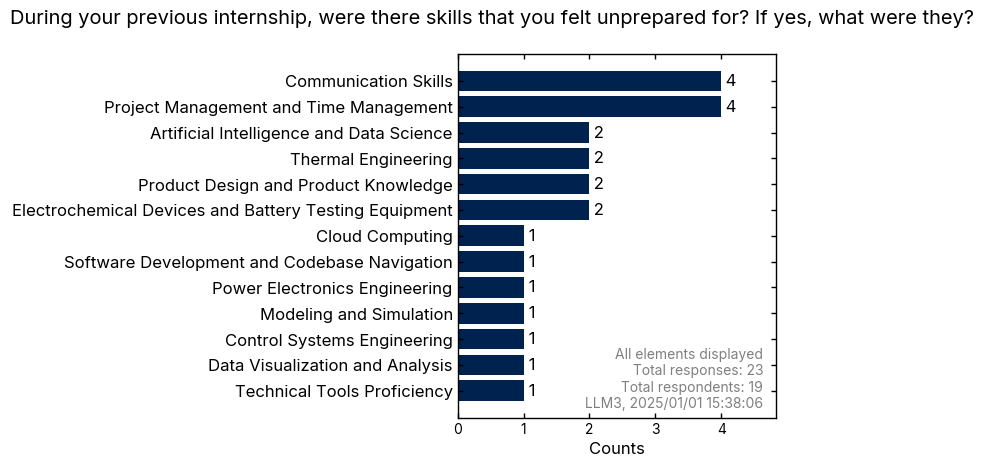

In [14]:
plotter.make_bar_plot_from_dict(counter,
                                title=question['question'],
                                sorted=True,
                                annotation=f'LLM3, {time.strftime("%Y/%m/%d %H:%M:%S")}',
                                num_elements=100,
                                saveas=f'{question['tag']}_{time.strftime("%Y%m%d_%H%M%S")}.png'
)